In [ ]:
import os
import streamlit as st
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage,ToolMessage
from langgraph.graph import StateGraph, START, END
from typing import List, TypedDict,Optional
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

# -----------------------------
# 1. Load API Keys
# -----------------------------
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ['GROQ_API_KEY'] = groq_api_key

# -----------------------------
# 2. Define State
# -----------------------------
class ChatState(TypedDict):
    messages: List[dict]
    tool_calls: Optional[List]  # optional

# -----------------------------
# 3. Create the LLM
# -----------------------------
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama-3.1-8b-instant"
)

# -----------------------------
# 4. Define Tools
# -----------------------------
@tool
def add_numbers(input: str) -> str:
    """Add two numbers provided as 'a,b'."""
    try:
        a, b = input.split(",")
        return str(float(a) + float(b))
    except:
        return "Error: Use format 'a,b'"
tools = [
    add_numbers,
    TavilySearchResults(tavily_api_key=os.getenv("TAVILY_API_KEY")),
]

# -----------------------------
# 5. Define Node Logic
# -----------------------------
def chatbot_node(state: ChatState):
    """LLM decides: respond OR call tools."""
    conversation = state["messages"]
    response = llm.invoke(conversation)
    print('response: ',response)
    print('tool_calls: ',response.tool_calls)
    conversation.append({"role": "assistant", "content": response.content})
    return {
        "messages": conversation,
        "tool_calls": response.tool_calls
    }

def tool_node(state: ChatState):
    """Execute tool calls."""
    conversation = state["messages"] ## [{"role": "user", "content": "search Google"},{"role": "assistant", "tool_calls": [...]}]
    outputs = []

    for call in state["tool_calls"]: ## { "name": "search_tool","args": {"query": "weather in London"}, "id": "12345"}
        name = call["name"]
        args = call["args"]

        # run the tool
        for tool in tools:
            if tool.name == name:
                result = tool.run(args)
                outputs.append(
                    ToolMessage(content=result, tool_call_id=call["id"])
                )

    conversation += outputs

    return {
        "messages": conversation,
        "tool_calls": None
    }

# --------------------------
# 6. Conditional Routing
# This is a function or callable that decides which branch to take.
# It should return a string key that matches one of the keys in the dictionary in 'graph.add_conditional_edges
# --------------------------
def tools_condition(state: ChatState):
    """Route to tool node only if there's a tool call."""
    if state.get("tool_calls"):
        return "needs_tools"
    return "no_tools"

# -----------------------------
# 7. Build the Graph
# -----------------------------
graph = StateGraph(ChatState)
graph.add_node("chatbot", chatbot_node)
graph.add_node("tools", tool_node)
graph.add_edge(START, "chatbot")
# Conditional edges mean: where the graph goes next depends on some condition.
# Unlike add_edge, which always goes to the same next node, add_conditional_edges lets you branch based on runtime logic.
graph.add_conditional_edges(
    "chatbot", # The graph evaluates the condition after running the chatbot node.
    tools_condition,
    {
        "needs_tools": "tools", # This is a mapping from the output of tools_condition to the next node. "needs_tools": "tools" → if tools_condition returns "needs_tools", go to the node named "tools".
        "no_tools": END, #  "no_tools": END → if tools_condition returns "no_tools", go to the END node, meaning the workflow stops.
    }
)
graph.add_edge("tools", "chatbot")

# -----------------------------
# 8. Compile Graph
# -----------------------------
chatbot_app = graph.compile()

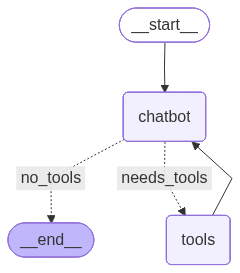

In [4]:
from IPython.display import Image, display

try:
    display(Image(chatbot_app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

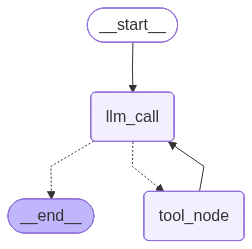

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (cbqd3tspg)
 Call ID: cbqd3tspg
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The function call has been made and the result is 7.


In [18]:
# Step 1: Define tools and model

from langchain.tools import tool
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv


load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ['GROQ_API_KEY'] = groq_api_key

model = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama-3.1-8b-instant"
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

# Step 2: Define state

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

# Step 3: Define model node
from langchain_core.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }


# Step 4: Define tool node

from langchain_core.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Step 5: Define logic to determine whether to end

from typing import Literal
from langgraph.graph import StateGraph, START, END


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

# Step 6: Build agent

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()


from IPython.display import Image, display
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()